In [1]:
#%%writefile read_data.py
#%load read_data.py
import pandas as pd
import os
def load_data(filename):
    csv_path = os.path.join(".", filename)
    return pd.read_csv(csv_path)

room_data = load_data('train_data.txt')
room_data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


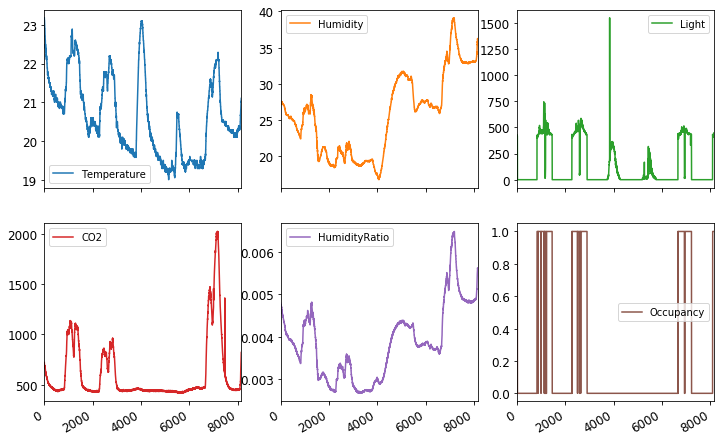

In [2]:
#%%writefile plot_data.py
#%load plot_data.py
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
room_data.plot(subplots=True, layout=(2,3), figsize=(12, 8));

(8143, 5)
[ 2.51847007  0.27852622  1.57376283  0.36494808  1.09175697]


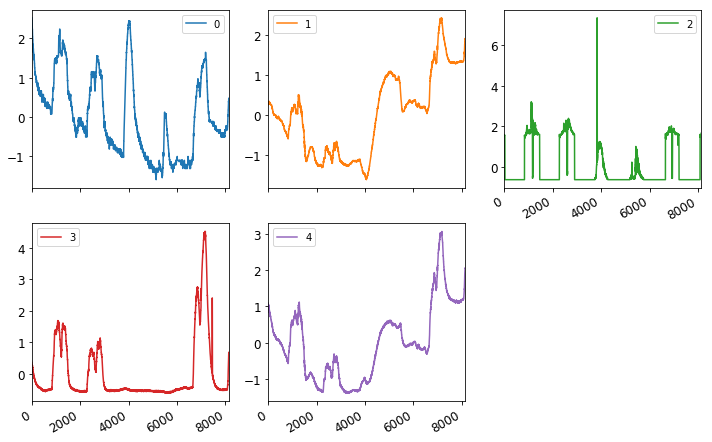

In [3]:
#%%writefile preprocess_data.py
# %load preprocess_data.py

from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import re
room_data.describe()

#attributes = [attr for attr in list(data) if not re.search(attr, r'date|Occupancy')]
# Create a class to select numerical or categorical columns
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# list of attributes for the DataFrameSelector (pandas to numpy)
room_attrib = [attr for attr in list(room_data) if not re.search(attr, r'date|Occupancy')]
pipeline = Pipeline([
    ('selector', DataFrameSelector(room_attrib)),
    ('std_scaler', StandardScaler()),
])

room_prepared = pipeline.fit_transform(room_data)
print(np.shape(room_prepared))
print(room_prepared[0])
df = pd.DataFrame(room_prepared)
df.plot(subplots=True, layout=(2,3), figsize=(12, 8));

In [4]:
#%%writefile train.py
# %load train.py
import os as os
import numpy as np
import scipy.io
import scipy.optimize as optimization

N_EPOCH = 100

n_mis = []
def dwp(w,d,X):
    # using numpy einstein summation to vectorize the computation
    # calculating w.x.d -- w.x.d < 0 => incorrect classification
    C = d*np.einsum('i,ji->j', w, X) # shape is (100,)
    # use enumerate for the equivalent to each_with_index (Ruby)
    xd = [ d[i]*X[i] for i,c in enumerate(C) if c <= 0]
    # the error is the number of misclassified teachers
    E = len(xd)/float(len(d))
    # sum xd element-wise
    # dw is x.t summed over misclassified teachers
    dw =  np.einsum('ij->j',xd) if(len(xd) > 0) else 0
    return dw, E

def train():
    # data
    room_with_bias = np.full((len(room_prepared),6),1.0)
    room_with_bias[:,1:] = room_prepared
    # shape is (nrow, 6)
    X = room_with_bias
    #print(np.shape(X))
    # use domain -1,1 for teachers so we can use x.w.d<0 for the classification test
    # shpae is (nrow,1)
    t = [z if z == 1 else -1 for z in room_data['Occupancy']]
    #print(np.shape(t))
    # starting vector of weights
    w = np.zeros((np.shape(room_with_bias)[1]))
    perf = []
    # sweep through the data N_EPOCH times
    for _ in range(N_EPOCH):
         dw, E = dwp(w,t,X)
         w += dw
         perf.append(1-E)
    return w, perf

# invoke main
w_trained, performance = train()


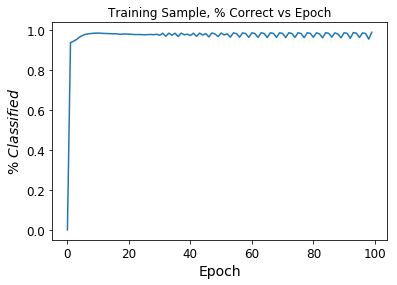

In [5]:
#%%writefile plot_train_perf.py
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.ylabel(r'$\%\ Classified$')
plt.xlabel('Epoch')
plt.title('Training Sample, % Correct vs Epoch')
plt.plot(performance)

0.9520098441345365


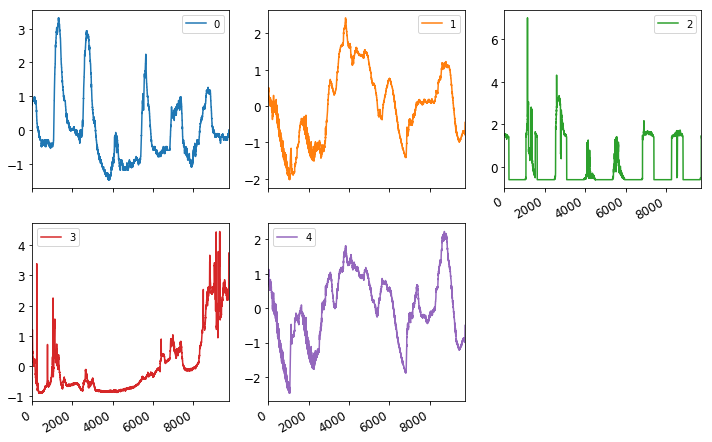

In [6]:
#%%writefile test.py
def test(w):
    test_data = load_data('test_data.txt')
    # same transform pipeline on the test data as the training data
    test_prepared = pipeline.fit_transform(test_data)
    df = pd.DataFrame(test_prepared)
    df.plot(subplots=True, layout=(2,3), figsize=(12, 8));
    # add a bias to the prepared test data
    test_with_bias = np.full((len(test_prepared),6),1.0)
    test_with_bias[:,1:] = test_prepared
    # shape is (nrow, 6)
    X = test_with_bias
    t = [z if z == 1 else -1 for z in test_data['Occupancy']]
    # all we care about here is E
    _, E = dwp(w, t, X)
    print(1-E)

test(w_trained)